## Student Name: Tadhg Philibin e Silva
## Student ID: 22275363

In [207]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support
#from scipy import interp
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

## EDA - Exploratory Data Analysis

In [208]:
df = pd.read_csv("./seeds.csv")
df.head()

area  perimeter  compactness  length of kernel  width of kernel  \
0  15.26      14.84       0.8710             5.763            3.312   
1  14.88      14.57       0.8811             5.554            3.333   
2  14.29      14.09       0.9050             5.291            3.337   
3  13.84      13.94       0.8955             5.324            3.379   
4  16.14      14.99       0.9034             5.658            3.562   

   asymmetry coefficient  length of kernel groove  type  
0                  2.221                    5.220     1  
1                  1.018                    4.956     1  
2                  2.699                    4.825     1  
3                  2.259                    4.805     1  
4                  1.355                    5.175     1

In [209]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   area                     210 non-null    float64
 1   perimeter                210 non-null    float64
 2   compactness              210 non-null    float64
 3   length of kernel         210 non-null    float64
 4   width of kernel          210 non-null    float64
 5   asymmetry coefficient    210 non-null    float64
 6   length of kernel groove  210 non-null    float64
 7   type                     210 non-null    int64  
dtypes: float64(7), int64(1)
memory usage: 13.2 KB


All of our columns are numerical so no feature engineering of categorical variables will be necessary

In [210]:
df.isna().sum()

area                       0
perimeter                  0
compactness                0
length of kernel           0
width of kernel            0
asymmetry coefficient      0
length of kernel groove    0
type                       0
dtype: int64

Similarly, there are no missing values that we must impute

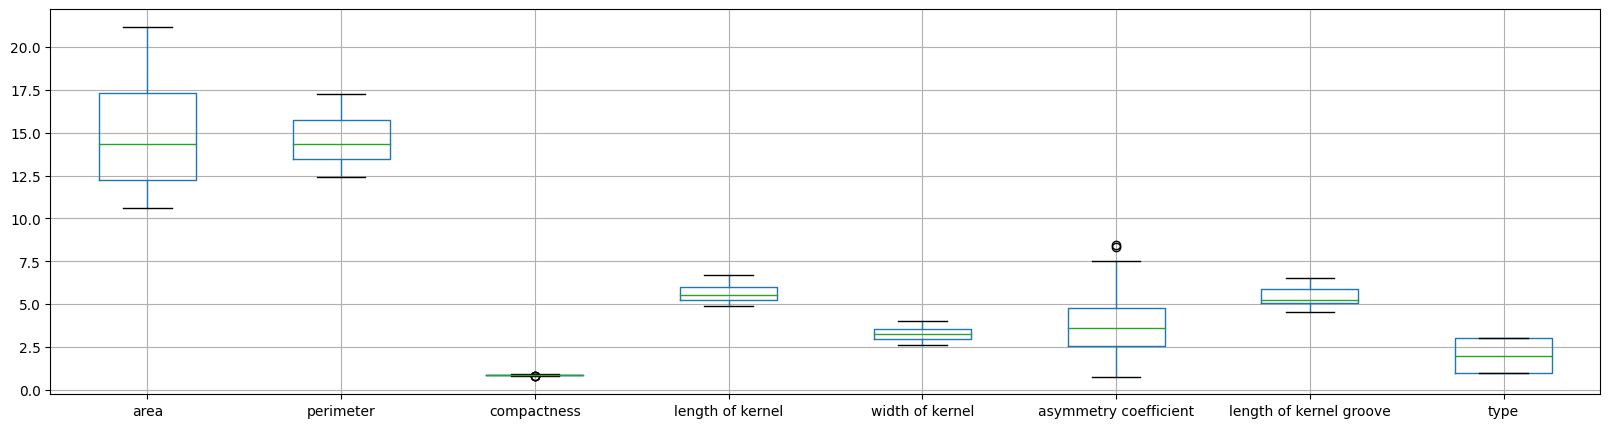

In [211]:
df.loc[:].boxplot(figsize=(20,5))
plt.show()

The **asymmetry coefficient** is the only feature with notable outliers.

#### Helper functions

In [212]:
class AddColumnNames(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(data=X, columns=self.columns)

In [213]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X[self.columns]

We will drop the **type** column and develop a new classification column

In [214]:
df = df.drop('type',axis=1)

To transform our problem into a binary classifcation problem, we will generate two new classes via KMeans clustering.

In [215]:
from sklearn.cluster import KMeans

In [216]:
model = KMeans(n_clusters=2, n_init='auto', max_iter=1000)
kmeans_data = df.copy(deep=True)

In [217]:
scaler = StandardScaler()
scaled_X = scaler.fit_transform(kmeans_data)

In [218]:
cluster_labels = model.fit_predict(scaled_X)

In [219]:
cluster_labels

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

## Classification context

For the purposes of the exercise, we will suppose that some amount of the seeds have been exposed to strong pesticides. Exposure to the pesticides prolongs the lifespan but limits the quality. The bags of seeds are of mixed type and sold on an organic/non-organic basis. Thus it is important that:

1. The organic seeds are not mixed with the pesticide-exposed seeds. Otherwise, purchasers of the pesticide/non-organic seeds will have a partially rotting bag before the listed expiry date.
2. Not too many pesticide seeds get included with the organic seeds. This is not a huge concern, but too many will degrade the quality of the product.




In [220]:
df['pesticide'] = cluster_labels

- **0** will represent organic seeds
- **1** will represent pesticide/non-organic seeds

Now that we have our new classification, we can explore the two binary classifaction methods.

To develop our preprocessing pipeline, we will separate the asymmetry coefficient from the other features

The **asymmetry coefficient** feature is the only one with outliers and since the StandardScaler cannot guarantee balanced feature scales in the presence of outliers, for this feature we will use RobustScaler, and StandardScaler for all others.

In [221]:
names_all = [c for c in df if c not in ['pesticide']]
names_outliers = ['asymmetry coefficient']
names_no_outliers = list(set(names_all) - set(names_outliers))

In [222]:
class AddColumnNames(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(data=X, columns=self.columns)

In [223]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X[self.columns]

In [224]:
preprocess_pipeline = make_pipeline(
    AddColumnNames(columns=names_all),
    FeatureUnion(transformer_list=[
        ("outlier_columns", make_pipeline(
            ColumnSelector(columns=names_outliers),
            FunctionTransformer(np.log, validate=True),
            RobustScaler()
        )),
        ("no_outlier_columns", make_pipeline(
            ColumnSelector(columns=names_no_outliers),
            StandardScaler()
        ))
    ])
)

In [225]:
y = df['pesticide']
X = df.drop('pesticide', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

# Classification

### Support Vector Classification

In [226]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('svm', svm.SVC(probability=True))])

In [227]:
param_grid = {
    'svm__C': [0.1, 1, 10, 100],  
    'svm__gamma': [1, 0.1, 0.01, 0.001], 
    'svm__kernel': ['rbf', 'linear', 'poly']}

In [228]:
search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        Pipeline(steps=[('addcolumnnames',
                                                         AddColumnNames(columns=['area',
                                                                                 'perimeter',
                                                                                 'compactness',
                                                                                 'length '
                                                                                 'of '
                                                                                 'kernel',
                                                                                 'width '
                                                                                 'of '
                                                                                 'kernel',
                                                                                 'asymmetry '
                                                                                 'coefficient',
                                                                                 'length '
                                                                                 'of '
                                                                                 'kernel '
                                                                                 'groove'])),
                                                        ('featureunion',
                                                         FeatureUnion(transformer_list=[('outlier_columns',
                                                                                         Pipeline(steps=[('columnselector',
                                                                                                          Col...
                                                                                         Pipeline(steps=[('columnselector',
                                                                                                          ColumnSelector(columns=['length '
                                                                                                                                  'of '
                                                                                                                                  'kernel',
                                                                                                                                  'perimeter',
                                                                                                                                  'width '
                                                                                                                                  'of '
                                                                                                                                  'kernel',
                                                                                                                                  'area',
                                                                                                                                  'length '
                                                                                                                                  'of '
                                                                                                                                  'kernel '
                                                                                                                                  'groove',
                                                                                                                                  'compactness'])),
                                                                                                         ('standardscaler',
 

In [229]:
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

SVM_best_params = search.best_params_
SVM_best_model = search.best_estimator_

Best CV score = 0.994:
Best parameters:  {'svm__C': 1, 'svm__gamma': 1, 'svm__kernel': 'rbf'}


### Random Forest Classification

In [230]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('rf', RandomForestClassifier())])

In [231]:
param_grid = {
    'rf__n_estimators' : [10,20,30],
    'rf__max_depth': [2, 4, 6, 8]
}

In [232]:
search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        Pipeline(steps=[('addcolumnnames',
                                                         AddColumnNames(columns=['area',
                                                                                 'perimeter',
                                                                                 'compactness',
                                                                                 'length '
                                                                                 'of '
                                                                                 'kernel',
                                                                                 'width '
                                                                                 'of '
                                                                                 'kernel',
                                                                                 'asymmetry '
                                                                                 'coefficient',
                                                                                 'length '
                                                                                 'of '
                                                                                 'kernel '
                                                                                 'groove'])),
                                                        ('featureunion',
                                                         FeatureUnion(transformer_list=[('outlier_columns',
                                                                                         Pipeline(steps=[('columnselector',
                                                                                                          Col...
                                                                                                          RobustScaler())])),
                                                                                        ('no_outlier_columns',
                                                                                         Pipeline(steps=[('columnselector',
                                                                                                          ColumnSelector(columns=['length '
                                                                                                                                  'of '
                                                                                                                                  'kernel',
                                                                                                                                  'perimeter',
                                                                                                                                  'width '
                                                                                                                                  'of '
                                                                                                                                  'kernel',
                                                                                                                                  'area',
                                                                                                                                  'length '
                                                                                                                                  'of '
                                                                                                                                  'kernel '
                                                                                                                                  'groove',
                                    

In [233]:
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.988:
Best parameters:  {'rf__max_depth': 2, 'rf__n_estimators': 10}


### Compare classifiers on Test set

In [234]:
mean_fpr = np.linspace(start=0, stop=1, num=100)

In [235]:
def evaluate_model(X_test, y_test, model):
    _probabilities = model.predict_proba(X_test)[:, 1]
    _predicted_values = model.predict(X_test)
    _accuracy = accuracy_score(y_test, _predicted_values)
    _precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])
    
    # compute fpr and tpr values for various thresholds 
    # by comparing the true target values to the predicted probabilities for class 1
    _fpr, _tpr, _ = roc_curve(y_test, _probabilities)
        
    # compute true positive rates for the values in the array mean_fpr
    _tpr_transformed = np.array([np.interp(mean_fpr, _fpr, _tpr)])
    
    _auc = auc(_fpr, _tpr)
            
    return _accuracy, _precision[0], _recall[0], _f1_score[0], _tpr_transformed, _auc

In [236]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [237]:
def draw_confusion_matrix(y_test, preds):
    cm = confusion_matrix(y_test, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['Organic','Pesticide'])
    disp.plot()
    plt.show()

In [238]:
SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score, SVM_tpr, SVM_auc = evaluate_model(X_test, y_test, SVM_best_model)
RF_accuracy, RF_precision, RF_recall, RF_f1_score, RF_tpr, RF_auc = evaluate_model(X_test, y_test, RF_best_model)

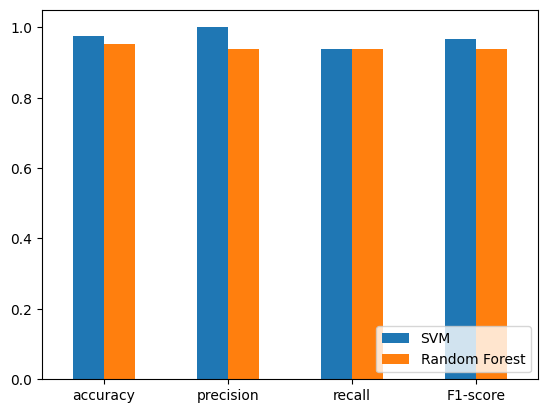

In [239]:
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

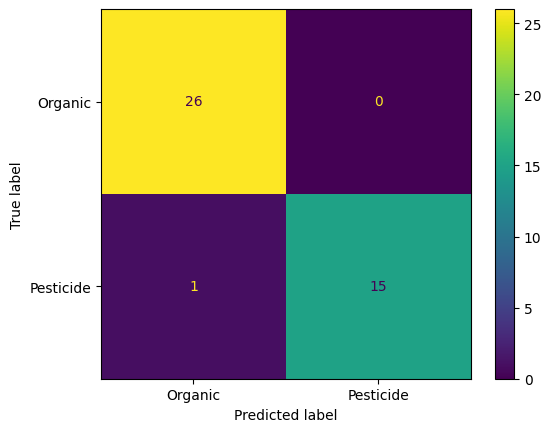

In [240]:
svm_preds = SVM_best_model.predict(X_test)
draw_confusion_matrix(y_test, svm_preds)

### Support Vector Classifier analysis

**One False Negative** has occured, and no False Positives. In our proposed classification context, this means that some very small amount of pesticide/non-organic seeds will be mixed among the organic bags of seeds. This perhaps might anger some organic purist, but it won't compromise the product in a significant way. 

**Precision is high**, and that is the most important metric in our situation because the cost of False Positives is high for us.

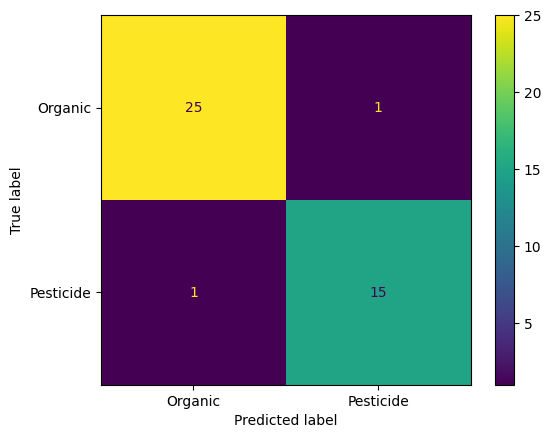

In [241]:
rf_preds = RF_best_model.predict(X_test)
draw_confusion_matrix(y_test, rf_preds)

### Random Forest analysis

**One false postive and one false positive have occured**
In our proposed classification context, this would be a case of some organic seed being mixed in with a bag of longer-life seeds which is not ideal. If the model is going to misclassify, it would ideally be the opposite case.


**Both precision and recall are good, but neither are perfect** with this model.

#### Support Vector Classifier  is superior to Random Forest in this context

---

### Naive Bayes classifier

In [242]:
from sklearn.naive_bayes import GaussianNB
nb_model = GaussianNB()
nb_model.partial_fit(X_train, y_train, np.unique(y_train))

GaussianNB()

In [243]:
NB_accuracy, NB_precision, NB_recall, NB_f1_score, NB_tpr, NB_auc = evaluate_model(X_test, y_test, nb_model)

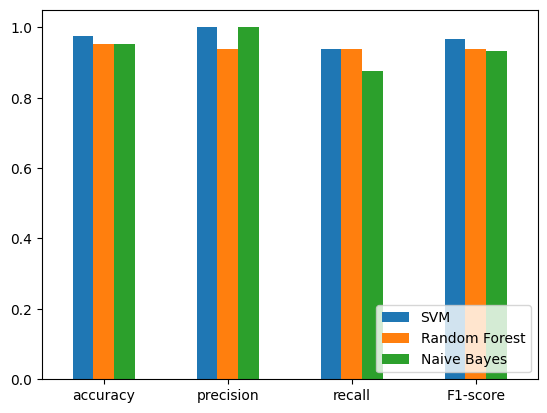

In [244]:
NB_metrics = np.array([NB_accuracy, NB_precision, NB_recall, NB_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics, 'Naive Bayes': NB_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

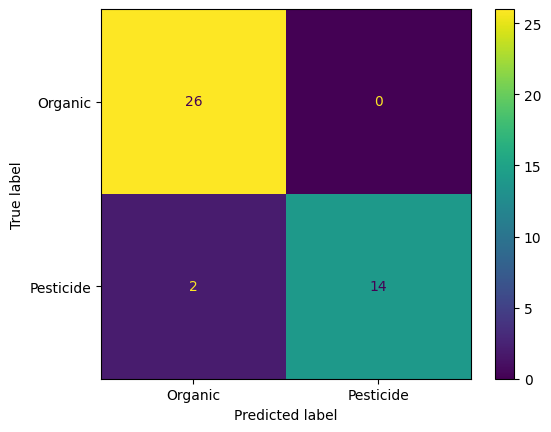

In [245]:
nb_preds = nb_model.predict(X_test)
draw_confusion_matrix(y_test, nb_preds)

### Naive Bayes analysis

**No false postives** have occured and two false negatives. 


**Precision** is excellent but Recall is the worst we have seen so far.

### KNeighbors Classifier

In [246]:
from sklearn.neighbors import KNeighborsClassifier

In [247]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('knn', KNeighborsClassifier())])

In [248]:
param_grid = {
    'knn__n_neighbors': [3, 5, 9, 12, 15],  
    'knn__weights': ['uniform', 'distance'], 
    'knn__algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'knn__leaf_size': [15,30,45]}

In [249]:
search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        Pipeline(steps=[('addcolumnnames',
                                                         AddColumnNames(columns=['area',
                                                                                 'perimeter',
                                                                                 'compactness',
                                                                                 'length '
                                                                                 'of '
                                                                                 'kernel',
                                                                                 'width '
                                                                                 'of '
                                                                                 'kernel',
                                                                                 'asymmetry '
                                                                                 'coefficient',
                                                                                 'length '
                                                                                 'of '
                                                                                 'kernel '
                                                                                 'groove'])),
                                                        ('featureunion',
                                                         FeatureUnion(transformer_list=[('outlier_columns',
                                                                                         Pipeline(steps=[('columnselector',
                                                                                                          Col...
                                                                                                          ColumnSelector(columns=['length '
                                                                                                                                  'of '
                                                                                                                                  'kernel',
                                                                                                                                  'perimeter',
                                                                                                                                  'width '
                                                                                                                                  'of '
                                                                                                                                  'kernel',
                                                                                                                                  'area',
                                                                                                                                  'length '
                                                                                                                                  'of '
                                                                                                                                  'kernel '
                                                                                                                                  'groove',
                                                                                                                                  'compactness'])),
                                                                                                         ('standardscaler',
                                                                                                          StandardScaler())])

In [250]:
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)
KNN_best_params = search.best_params_
KNN_best_model = search.best_estimator_

Best CV score = 0.988:
Best parameters:  {'knn__algorithm': 'ball_tree', 'knn__leaf_size': 15, 'knn__n_neighbors': 5, 'knn__weights': 'distance'}


### Discussion of parameters

- Weight function = distance, default = uniform
- leaf_size = 15, default = 30
- n_neighbors = 3, default = 5
- algorithm = ball_tree

The Grid search converged on an optimal choice of parameters that reduces the leaf_size and changes the weight function.
The default value for the **algorithm** parameter is 'auto', which will try to choose the optimal algorithm based on the training set. By supplying all the algorithm types and letting grid search choose **BallTree**, and we can speculate that the 'auto' functionality may have chosen the same.



In [251]:
KNN_accuracy, KNN_precision, KNN_recall, KNN_f1_score, KNN_tpr, KNN_auc = evaluate_model(X_test, y_test, KNN_best_model)

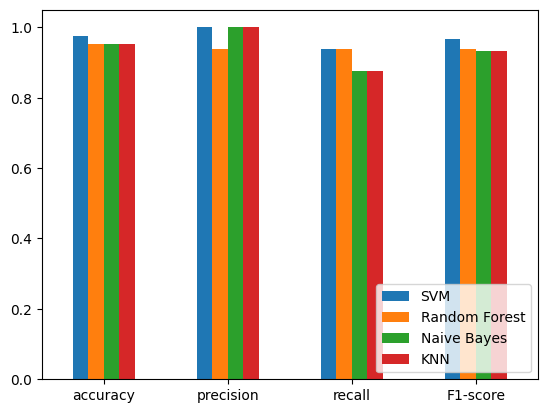

In [252]:
KNN_metrics = np.array([KNN_accuracy, KNN_precision, KNN_recall, KNN_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame(
    {
        'SVM': SVM_metrics, 
        'Random Forest': RF_metrics, 
        'Naive Bayes': NB_metrics, 
        'KNN': KNN_metrics
    }, 
    index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

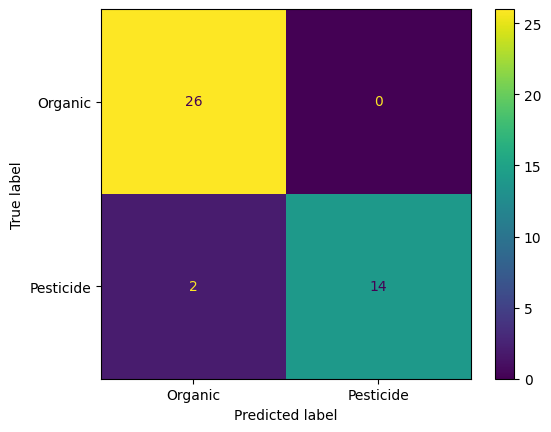

In [253]:
knn_preds = KNN_best_model.predict(X_test)
draw_confusion_matrix(y_test, knn_preds)

### KNN analysis

**No false postives** have occured and two false negatives. 

KNN performed equally to Naive Bayes